In [1]:
import uuid
import joblib
import json
from model_selection import load_dataset, df_train_test_split, model_evaluate, resize
from settings import BASE_DIR
import Preprocess as ps
from nltk.stem import SnowballStemmer
import TFIDF_Models as cnb
from sklearn.model_selection import RandomizedSearchCV
import scipy.stats.distributions as dists
import time

# explicit negations
negations = {"isn't":"is not", "aren't":"are not", "wasn't":"was not", "weren't":"were not",
            "haven't":"have not","hasn't":"has not","hadn't":"had not","won't":"will not",
            "wouldn't":"would not", "don't":"do not", "doesn't":"does not","didn't":"did not",
            "can't":"can not","couldn't":"could not","shouldn't":"should not","mightn't":"might not",
            "mustn't":"must not"}
# convert twitter emojis in twitch style emojis
emojis = {':)': 'smile', ':-)': 'smile', ';d': 'wink', ':-E': 'vampire', ':(': 'sad',
      ':-(': 'sad', ':-<': 'sad', ':P': 'raspberry', ':O': 'surprised',
      ':-@': 'shocked', ':@': 'shocked',':-$': 'confused',
      ':#': 'mute', ':X': 'mute', ':^)': 'smile', ':-&': 'confused', '$_$': 'greedy',
      '@@': 'eyeroll', ':-!': 'confused', ':-D': 'smile', ':-0': 'yell', 'O.o': 'confused',
      '<(-_-)>': 'robot', 'd[-_-]b': 'dj', ":'-)": 'sadsmile', ';)': 'wink',
      ';-)': 'wink', 'O:-)': 'angel','O*-)': 'angel','(:-D': 'gossip', '=^.^=': 'cat'}
regex_subs = {
                r"https?://[^s]+" : "URL", # replace any url with URL
                "www.[^ ]+" : "URL", # replace any url with URL
                r"@[^\s]+" : "USR", # replace any user tag with USR (the tag system is the same also in twitch)
                r"(.)\1\1+" : r"\1\1", # replace 3 consecutive chars with 2
                r"[\s]+" : " ", # remove consec spaces
                "#[a-z0-9]*" : "" #remove hashtags, they are not used in twitch chats
             }
sbStem = SnowballStemmer("english", True)
preprocess = ps.Preprocess(negations, emojis, regex_subs, sbStem)

In [2]:
path = "{BaseDir}/Advanced_Machine_Learning_Project/data/dataset.csv".format(BaseDir=BASE_DIR)
columns = ["sentiment", "ids", "date", "flag", "user", "text"]
final_columns = ["text", "sentiment"]
df = load_dataset(path, columns, final_columns)
# df = resize(df, 50, "sentiment", 4)

loading dataset...
...dataset loaded


In [3]:
df = preprocess.df_pre_process(df, "text", "sentiment")
X_train, X_test, Y_train, Y_test = df_train_test_split(df, "text", "sentiment",test_size=0.05)

starting preprocessing...
...preprocessing completed
starting splitting dataset...
...dataset splitted


In [4]:
model = cnb.TFIDFLogisticRegression()
params_grid = [dict(
                tfidf_max_features=dists.randint(1, 50000000),
                ngram_range=[(1, 2)],
                penalty=['l1', 'l2', 'elasticnet', 'none'],
                tol=dists.uniform(0.00001, 0.001),
                C=dists.uniform(0.1, 2.0),
                fit_intercept=[True, False],
                solver=['saga'],
                max_iter=dists.randint(100, 1000 + 1),
                l1_ratio=dists.uniform(0.0, 1.0)
                        )]
trys = RandomizedSearchCV(model, param_distributions=params_grid, n_iter=1, n_jobs=1, return_train_score=True)

TFIDFLogisticRegression()


In [ ]:
start = time.time()
search = trys.fit(X_train, Y_train)
end = time.time()

starting vectorizing words...
...words vectorized


In [ ]:
filename = uuid.uuid4().hex
joblib.dump(search, filename)
data = {
    'time':(end - start),
    'n_parameters':len(search.cv_results_['params']),
    'cv_result' : str(search.cv_results_),
    'best_estimator': str(search.best_estimator_),
    'best_score': search.best_score_,
    'best_param': search.best_params_,
    'model_name': filename
}
with open("{BaseDir}/Advanced_Machine_Learning_Project/ML/GeneratedModelsInfo.json".format(BaseDir=BASE_DIR),'a') as f:
            json.dump(data, f, indent=1)

starting vectorizing words...
...words vectorized
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.33      1.00      0.50         1

    accuracy                           0.33         3
   macro avg       0.17      0.50      0.25         3
weighted avg       0.11      0.33      0.17         3



/home/annabelle/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/annabelle/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/annabelle/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


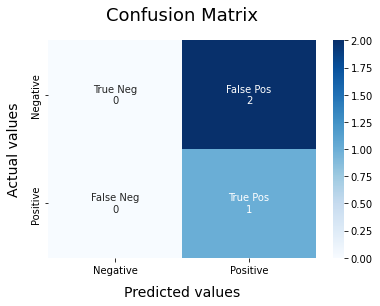

In [12]:
# model = joblib.load(filename)
model_evaluate(search, X_test, Y_test)